In [1]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification
from imblearn.under_sampling import RandomUnderSampler
from keras.optimizers import SGD,Adam
from datetime import datetime
maintenant = datetime.now()
print(maintenant)
import tensorflow as tf

# activation GPU

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)




from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense # Pour construire un réseau de neurones et
                                                 # instancier une couche d'entrée et une couche den
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
import matplotlib.pyplot as plt
import os
#import cv2
import gc
import itertools # Pour créer des itérateurs
import pickle

2024-03-24 13:50:25.134796
1 Physical GPUs, 1 Logical GPUs


In [2]:
VERSION = "_V01"
SUFFIXE_FICHIER = "ResNet50" + VERSION
STRATEGIE = "sampling_strategy_B1" + VERSION +".csv" # effectifs par classe retenu après over et under sampling
IMGSIZE       = 400    # Taille de l'image en input
EPOCH         = 20     # nombre d'epoch 
BATCH_SIZE    = 32     # traitement par batch d'images avant la descente de gradient
FREEZE_LAYERS = 175     # pour un EfficientNetB1 freeze de réapprentissage de certaines couches (175 couches au total)
NB_PAR_LABEL_MAX = 5000 # nombre maximun d'enregistrement par label = undersampling
NB_PAR_LABEL_MIN = 2000 # nombre maximun d'enregistrement par label = oversampling
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé

In [3]:
import sys
sys.path.append('../src')
import Bibli_DataScience_3_2 as ds
import CNN_DataScience_2 as cnn

section :  ['DOSSIER', 'FICHIER']


In [4]:
# Pour recharger si nesséssaire
import imp
imp.reload(ds)
imp.reload(cnn)

section :  ['DOSSIER', 'FICHIER']


<module 'CNN_DataScience_2' from 'E:\\Manuel\\PROJET\\Rakuten_Images_Classification_TensorFlow\\notebooks\\../src\\CNN_DataScience_2.py'>

In [4]:
# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)
#cat=df_target['prdtypecode'].sort_values().unique()
nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']
Lcat=df_target.sort_values(by = ['prdtypecode'])['prdtypecode'].unique()
Lcat

array([  10,   40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301,
       1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522,
       2582, 2583, 2585, 2705, 2905], dtype=int64)

In [5]:
df['nom_image']=df.apply(lambda row: "image_" +  str(row['imageid']) 
                                     + "_product_" + str(row['productid']) + ".jpg",axis=1)
print("Nb enreg ", str(df.shape[0]))
df_img=df.copy()

Nb enreg  84916


In [6]:
folder_path = ds.get_RACINE_IMAGES() 
df['filepath']=df['nom_image'].apply(lambda x : os.path.join(folder_path, x))

## test de lecture d'image¶

Taille de l'image : (500, 500, 3)


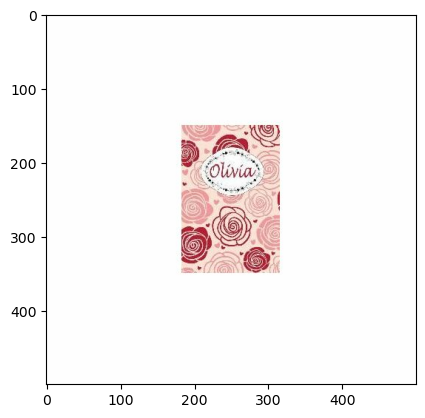

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Chemin de l'image
filename = df.nom_image[0]
filepath = os.path.join(folder_path, filename)
# Lecture du fichier
im = tf.io.read_file(filepath)

# On décode le fichier
im = tf.image.decode_jpeg(im, channels=3)

print("Taille de l'image :", im.shape)

# Affichage du tensor
plt.imshow(im);

### REDIMENSIONNEMENT
Pour avoir un temps d'entrainement du modèle raisonnable,  
il est nécessaire de redimensionner les images.  
**A l'origine les images ont une taille de 500*500 pixels.**

In [8]:
filepath = df.filepath[0]
# Lecture du fichier
im = tf.io.read_file(filepath)
# On décode le fichier
im = tf.image.decode_jpeg(im, channels=3)
# Redimensionnement
tf.image.resize(im, size=(IMGSIZE,IMGSIZE))


<tf.Tensor: shape=(400, 400, 3), dtype=float32, numpy=
array([[[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       ...,

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 25

### Evaluation de la répartition des catégories

In [9]:
y_serie =pd.Series(df.prdtypecode).value_counts()
majority_class = y_serie.index[0]
print(majority_class)
y_serie

2583


prdtypecode
2583    10209
1560     5073
1300     5045
2060     4993
2522     4989
1280     4870
2403     4774
2280     4760
1920     4303
1160     3953
1320     3241
10       3116
2705     2761
1140     2671
2582     2589
40       2508
2585     2496
1302     2491
1281     2070
50       1681
2462     1421
2905      872
60        832
2220      824
1301      807
1940      803
1180      764
Name: count, dtype: int64

### UNDERSAMPLING
On effectue un undersampling définit par le paramètre : NB_PAR_LABEL_MAX (cf debut de programme)    
Ici **undersampling à 5000**

In [10]:
new_class_counts = y_serie.copy()
sampling_strategy=new_class_counts.to_dict()
for key in sampling_strategy:
  if sampling_strategy[key] > NB_PAR_LABEL_MAX:
    sampling_strategy[key] = NB_PAR_LABEL_MAX
del y_serie,new_class_counts
#print(type(sampling_strategy))
spstrag=pd.DataFrame.from_dict(sampling_strategy,orient='index').rename(columns={0:'Qunatity'})
spstrag.to_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE)
print("Stategie de sampling")
sampling_strategy

Stategie de sampling


{2583: 5000,
 1560: 5000,
 1300: 5000,
 2060: 4993,
 2522: 4989,
 1280: 4870,
 2403: 4774,
 2280: 4760,
 1920: 4303,
 1160: 3953,
 1320: 3241,
 10: 3116,
 2705: 2761,
 1140: 2671,
 2582: 2589,
 40: 2508,
 2585: 2496,
 1302: 2491,
 1281: 2070,
 50: 1681,
 2462: 1421,
 2905: 872,
 60: 832,
 2220: 824,
 1301: 807,
 1940: 803,
 1180: 764}

In [11]:
print(df.filepath.shape)
print(df.prdtypecode.shape)
X=np.array(df.filepath)
y=np.array(df.prdtypecode)
X=X.reshape(-1,1)
y=y.reshape(-1,1)
X.shape

(84916,)
(84916,)


(84916, 1)

In [12]:

rUs = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_ru, y_ru = rUs.fit_resample(X, y  )
#del   X_Reshape, y
#gc.collect()
print(len(X_ru))
print(len(X_ru))

79589
79589


In [13]:
from sklearn.model_selection import train_test_split

import numpy as np

X_train_ru, X_test_path, y_train_ru, y_test = train_test_split(X_ru, y_ru, train_size=0.8, random_state=1234,
                                                              stratify=y_ru,shuffle=True)

Après la répartition entre le jeu de test et le jeu d'entrainement  
**la classe la plus représentée** du jeu d'entrainement comporte **4000 occurences**

In [14]:
y_serie =pd.Series(y_train_ru).value_counts()
majority_class = y_serie.index[0]
print(majority_class)
y_serie

1560


1560    4000
1300    4000
2583    4000
2060    3994
2522    3991
1280    3896
2403    3819
2280    3808
1920    3442
1160    3162
1320    2593
10      2493
2705    2209
1140    2137
2582    2071
40      2006
2585    1997
1302    1993
1281    1656
50      1345
2462    1137
2905     698
60       666
2220     659
1301     646
1940     642
1180     611
Name: count, dtype: int64

### OVERSAMPLING
On effectue un oversampling définit par le paramètre : B_PAR_LABEL_MIN (cf debut de programme)   
On utilisera par la suite un génarateur d'images pour générer des images différentes de chaque enregistrement   
**ici oversampling à 2000.**

In [15]:
new_class_counts = y_serie.copy()
sampling_strategy=new_class_counts.to_dict()
for key in sampling_strategy:
  if sampling_strategy[key] <NB_PAR_LABEL_MIN :
  #if key in [1180,2220]:  
    sampling_strategy[key] = NB_PAR_LABEL_MIN
spstrag=pd.DataFrame.from_dict(sampling_strategy,orient='index').rename(columns={0:'Qunatity'})
spstrag.to_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE)  
print("Stategie de sampling")
sampling_strategy

Stategie de sampling


{1560: 4000,
 1300: 4000,
 2583: 4000,
 2060: 3994,
 2522: 3991,
 1280: 3896,
 2403: 3819,
 2280: 3808,
 1920: 3442,
 1160: 3162,
 1320: 2593,
 10: 2493,
 2705: 2209,
 1140: 2137,
 2582: 2071,
 40: 2006,
 2585: 2000,
 1302: 2000,
 1281: 2000,
 50: 2000,
 2462: 2000,
 2905: 2000,
 60: 2000,
 2220: 2000,
 1301: 2000,
 1940: 2000,
 1180: 2000}

In [16]:
from imblearn.over_sampling import RandomOverSampler
rOs = RandomOverSampler(sampling_strategy=sampling_strategy)
#rOs = RandomOverSampler(sampling_strategy=sampling_strategy,random_state=1234,shrinkage=1)
X_train_path, y_train = rOs.fit_resample(X_train_ru, y_train_ru)
X_train_path, y_train = shuffle(X_train_path, y_train, random_state=42)

In [17]:
y_res_series = pd.Series(y_train).value_counts()
print(y_res_series)


2583    4000
1300    4000
1560    4000
2060    3994
2522    3991
1280    3896
2403    3819
2280    3808
1920    3442
1160    3162
1320    2593
10      2493
2705    2209
1140    2137
2582    2071
40      2006
1281    2000
2585    2000
1302    2000
2462    2000
60      2000
2220    2000
1940    2000
1180    2000
1301    2000
2905    2000
50      2000
Name: count, dtype: int64


In [18]:

X_train_path=X_train_path.reshape(-1,)
print(X_train_path.shape)
X_test_path=X_test_path.reshape(-1,)
print(X_test_path.shape)

(73621,)
(15918,)


### Sauvegarde des jeux de données traités

In [19]:


with open(ds.get_RACINE_SAUVEGARDE() + 'X_train_path.pkl', 'wb') as f:
    pickle.dump(X_train_path, f)
with open(ds.get_RACINE_SAUVEGARDE() + 'X_test_path.pkl', 'wb') as f:
    pickle.dump(X_test_path, f)

In [20]:
print(X_train_path[:2])
print(y_train[:2])
print(X_test_path[:2])
print(y_test[:2])

['E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1316320287_product_4200885109.jpg'
 'E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1090712183_product_1548294779.jpg']
[  60 1180]
['E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1225886445_product_532978679.jpg'
 'E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1322834219_product_4231774754.jpg']
[2583 1920]


In [21]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_classes_converted = label_encoder.fit_transform(y_train)
#y_classes_train = label_encoder.transform(y_train)
# Maintenant, utilisez to_categorical
y_train_Network = to_categorical(y_classes_converted)
y_classes_converted = label_encoder.transform(y_test)
#y_classes_test = label_encoder.transform(y_test)
# Maintenant, utilisez to_categorical
y_test_Network = to_categorical(y_classes_converted)
print(y_train_Network.shape)
print(y_test_Network.shape)
with open(ds.get_RACINE_SAUVEGARDE() + 'y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open(ds.get_RACINE_SAUVEGARDE() + 'y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

(73621, 27)
(15918, 27)


In [ ]:
### augmentation des données
random_flip_left_right -> Retournez aléatoirement une image horizontalement (de gauche à droite)
random_flip_up_down -> Retournez aléatoirement une image verticalement (du haut vers  le bas)
random_brightness -> Ajuster la luminosité par un facteur aléatoire
random_contrast -> Ajuster le contraste par un facteur aléatoire
image.rot90 -> Rotation de 90 degrés

In [22]:

@tf.function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    #image = tf.image.rot90(image, k=1) 
    image = tf.image.random_crop(image,[400, 400, 3])
    return image



@tf.function
def load_and_augment_image(filepath, resize=(IMGSIZE,IMGSIZE)):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = augment_image(image)
    return tf.image.resize(image, resize)

@tf.function
def load_image(filepath, resize=(IMGSIZE,IMGSIZE)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels=3)
    return tf.image.resize(im, resize)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train_Network ))

dataset_train = dataset_train.map(lambda x, y : [load_and_augment_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)
#dataset_train = dataset_train.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)

dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test_Network))

dataset_test = dataset_test.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)

#dataset_train_aug = tf.data.Dataset.from_tensor_slices((X_train_path_aug, y_train_Network_aug))
#dataset_train_aug = dataset_train_aug.map(lambda x, y: [load_and_augment_image2(x), y], num_parallel_calls=-1).batch(32)



0 E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1316320287_product_4200885109.jpg
1 E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1090712183_product_1548294779.jpg
2 E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1283927670_product_4061632996.jpg
3 E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1134367019_product_2281179503.jpg
4 E:/Manuel/PROJET/Rakuten_Images_Classification_TensorFlow/data/images/image_train/image_1250471147_product_71652594.jpg


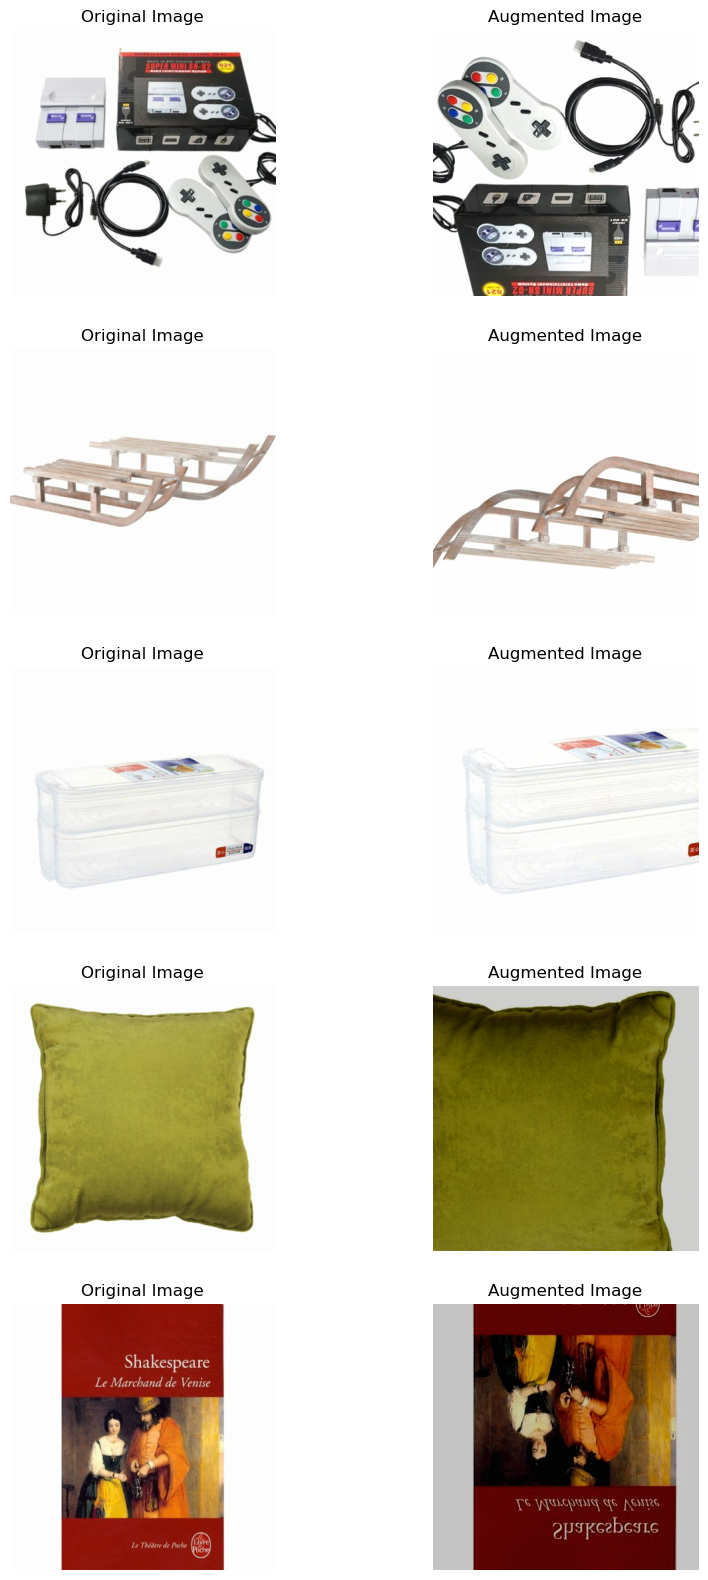

In [23]:
random_samples = X_train_path[:5]

# Créer une figure pour afficher les images
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i, nom in enumerate(random_samples):
    print(i, nom)
    # Charger l'image originale
    original_image = load_image(nom)/255.0

    # Redimensionner l'image pour l'affichage
    #resized_image = tf.image.resize(original_image, (IMGSIZE, IMGSIZE))

    # Charger l'image à l'aide de la fonction load_image
    augmented_image = load_and_augment_image(nom)/255.0

    # Afficher l'image originale et l'image augmentée
    axs[i, 0].imshow(original_image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original Image')

    axs[i, 1].imshow(augmented_image)
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Augmented Image')

plt.show()



@tf.function
def load_image(filepath, resize=(500,500)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=3)
    return tf.image.resize(im, resize)

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train_Network))

dataset_train = dataset_train.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(32)

dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test_Network))

dataset_test = dataset_test.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(32)



In [24]:
from tensorflow.keras.applications import ResNet50
#  help(tf.keras.applications)
# Chargement du modèleResNet50
base_model =  ResNet50(include_top=False, weights='imagenet',input_shape=(IMGSIZE,IMGSIZE,3))

niv1,niv2 = 0,0
for layer in base_model.layers[:FREEZE_LAYERS]:
    niv1  +=1
    layer.trainable = False
  
# Entrainement des derniers layers de classification
for layer in base_model.layers[FREEZE_LAYERS:]:
    niv2 += 1
    layer.trainable = True
base_model.summary()
print("Nb layers gelées : ",niv1)
print("nb layers dégelées : ", niv2)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 406, 406, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 200, 200, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

# II) Activation du meilleur modèle 

In [25]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
model = Sequential()
model.add(base_model) # Ajout du modèle EfficientB1
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(27, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 13, 13, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 346112)            0         
                                                                 
 dropout (Dropout)           (None, 346112)            0         
                                                                 
 dense (Dense)               (None, 1024)              354419712 
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 27)                2

In [26]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
saveweights = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_weights.h5'
trainacc  = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_train_acc.pkl'
valacc = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_al_acc.pkl'
loss = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_loss.pkl'
valloss = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_valloss.pkl'
dfpredict = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+ '_df_predict.csv'
testoriginal = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_y_test_original2.pkl'
predoriginal = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_test_pred_original2.pkl'

### a) lancement de l'entrainement

In [28]:
from tensorflow.keras import callbacks
NBETAPE=6
checkpoint = callbacks.ModelCheckpoint(filepath=ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_checkpoint.h5',
                                       monitor='val_loss',
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='min',
                                       save_freq='epoch')

# Réduction automatique du taux d'apprentissage

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=1,
                            mode='min')



training_history = model.fit(dataset_train, epochs=40, validation_data = dataset_test, callbacks=[lr_plateau])



Epoch 1/40
2301/2301 [==============================] - 953s 412ms/step - loss: 2.3343 - accuracy: 0.3457 - val_loss: 1.7832 - val_accuracy: 0.4808 - lr: 1.0000e-05
Epoch 2/40
2301/2301 [==============================] - 785s 341ms/step - loss: 1.9025 - accuracy: 0.4520 - val_loss: 1.6709 - val_accuracy: 0.5107 - lr: 1.0000e-05
Epoch 3/40
2301/2301 [==============================] - 785s 341ms/step - loss: 1.7367 - accuracy: 0.4950 - val_loss: 1.6033 - val_accuracy: 0.5269 - lr: 1.0000e-05
Epoch 4/40
2301/2301 [==============================] - 784s 341ms/step - loss: 1.6281 - accuracy: 0.5214 - val_loss: 1.5720 - val_accuracy: 0.5437 - lr: 1.0000e-05
Epoch 5/40
2301/2301 [==============================] - 785s 341ms/step - loss: 1.5407 - accuracy: 0.5465 - val_loss: 1.5591 - val_accuracy: 0.5376 - lr: 1.0000e-05
Epoch 6/40
2301/2301 [==============================] - 784s 341ms/step - loss: 1.4714 - accuracy: 0.5637 - val_loss: 1.5192 - val_accuracy: 0.5543 - lr: 1.0000e-05
Epoch 7/40

In [29]:
print("Sauvegarde des poids du modèle ... ")
model.save_weights(saveweights)
#print(saveweights)
print("-"*20)

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
tloss = training_history.history['loss']
tvalloss=training_history.history['val_loss']

print("Sauvegardes des precisions et les des pertes ... ")
with open(trainacc, 'wb') as f:
    pickle.dump(train_acc, f)
with open(valacc, 'wb') as f:
    pickle.dump(val_acc, f)
with open(loss, 'wb') as f:
    pickle.dump(tloss, f)
with open(valloss, 'wb') as f:
    pickle.dump(tvalloss, f)
#print(trainacc)
#print(valacc)
#print(loss)
#print(valloss)
print("-"*20)
    
y_test_original = np.argmax(y_test_Network, axis=1)
#print(y_test_Network[0])
y_test_original2=label_encoder.inverse_transform(y_test_original)

predictions = model.predict(dataset_test)
y_pred = np.argmax(predictions, axis=1)
test_pred_original2=label_encoder.inverse_transform(y_pred)

#print("-"*20)

top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_original2})

df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')

df_pred = pd.DataFrame()
for c in Lcat:
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
    df_pred = pd.concat([df_pred, df_temp], ignore_index=True)

print("Sauvegardes des rerultats ... ")
df_pred.to_csv(dfpredict)
with open(testoriginal, 'wb') as f:
    pickle.dump(y_test_original2, f)
with open(predoriginal, 'wb') as f:
    pickle.dump(test_pred_original2, f)
#print(testoriginal)
#print(predoriginal)

Sauvegarde des poids du modèle ... 
--------------------
Sauvegardes des precisions et les des pertes ... 
--------------------
498/498 [==============================] - 119s 238ms/step
Sauvegardes des rerultats ... 


### b) affichage des precisions et des pertes par époque

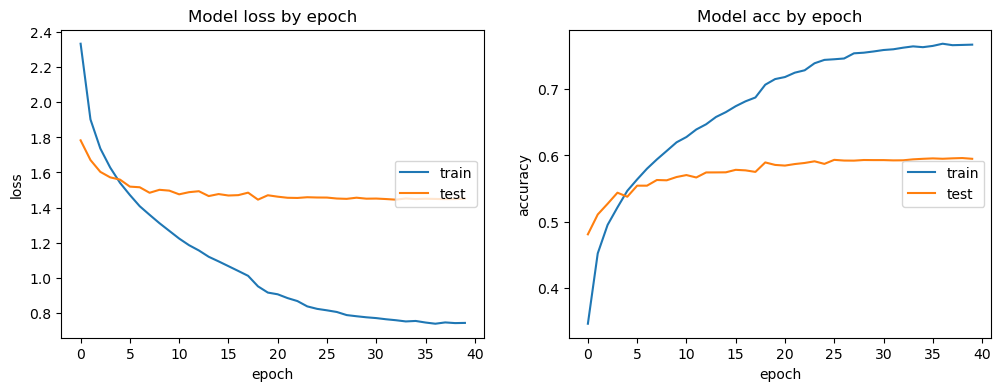

In [30]:



plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tloss)
plt.plot(tvalloss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

   

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

### c) affichage des 3 meilleurs prédictions par catégorie
classé par ordre d'échantillonage obtenu après over et under sampling

In [31]:

#=========================================================================
dfp=pd.read_csv(dfpredict)
dfs=pd.read_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE) # effectifs par classe retenu après over et under sampling
dfs.rename({'Unnamed: 0':'Categorie'},axis=1,inplace=True)
df_resume=dfs.merge(dfp,on='Categorie',how='inner')
df_resume.drop('Unnamed: 0',axis=1,inplace=True)
df_resume.head(27)

,Categorie,Qunatity,predict,pourc,predict2,pourc2,predict3,pourc3
0,1560,4000,1560,0.577000,2060,0.083000,2582,0.067000
1,1300,4000,1300,0.756000,1280,0.059000,50,0.034000
2,2583,4000,2583,0.797000,2585,0.022000,1300,0.022000
3,2060,3994,2060,0.474474,1560,0.087087,1920,0.078078
4,2522,3991,2522,0.712425,2583,0.030060,2403,0.021042
5,1280,3896,1280,0.418891,1300,0.152977,1140,0.081109
6,2403,3819,2403,0.597906,2280,0.134031,10,0.067016
7,2280,3808,2280,0.746849,2403,0.071429,10,0.055672
8,1920,3442,1920,0.768873,1560,0.053426,1320,0.047619
9,1160,3162,1160,0.911504,2462,0.016435,1281,0.013906


### d) matrice de confusion

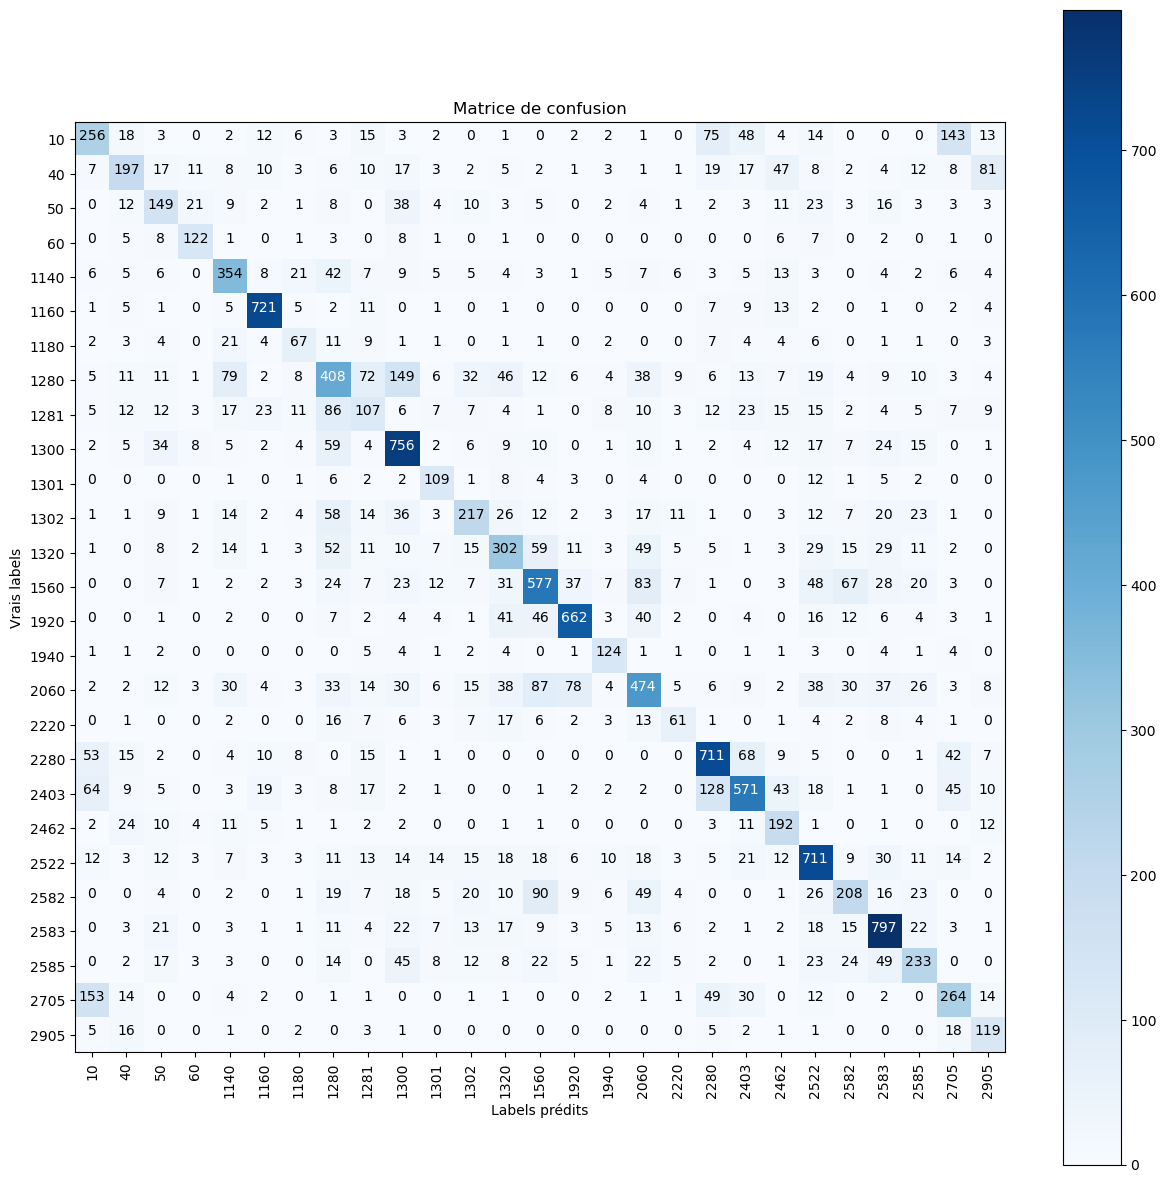

In [32]:
import itertools # Pour créer des itérateurs
#cnf_matrix = confusion_matrix(y_test, test_pred_orinal,labels=[10,2280,2403,2705,40,50,2462,1280,1281])
cnf_matrix = confusion_matrix(y_test, test_pred_original2,labels=sorted(list(set(y_test_original2))))
#print(cnf_matrix)


classes=sorted(list(set(y_test_original2)))
b=list(set(y_test_original2))

plt.figure(figsize=(15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation=90)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()


In [33]:
top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_original2})
df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,
10,0.410915,0.028892,0.004815,0.000000,0.003210,0.019262,0.009631,0.004815,0.024077,0.004815,...,0.000000,0.120385,0.077047,0.006421,0.022472,0.000000,0.000000,0.000000,0.229535,0.020867
40,0.013944,0.392430,0.033865,0.021912,0.015936,0.019920,0.005976,0.011952,0.019920,0.033865,...,0.001992,0.037849,0.033865,0.093625,0.015936,0.003984,0.007968,0.023904,0.015936,0.161355
50,0.000000,0.035714,0.443452,0.062500,0.026786,0.005952,0.002976,0.023810,0.000000,0.113095,...,0.002976,0.005952,0.008929,0.032738,0.068452,0.008929,0.047619,0.008929,0.008929,0.008929
60,0.000000,0.030120,0.048193,0.734940,0.006024,0.000000,0.006024,0.018072,0.000000,0.048193,...,0.000000,0.000000,0.000000,0.036145,0.042169,0.000000,0.012048,0.000000,0.006024,0.000000
1140,0.011236,0.009363,0.011236,0.000000,0.662921,0.014981,0.039326,0.078652,0.013109,0.016854,...,0.011236,0.005618,0.009363,0.024345,0.005618,0.000000,0.007491,0.003745,0.011236,0.007491
1160,0.001264,0.006321,0.001264,0.000000,0.006321,0.911504,0.006321,0.002528,0.013906,0.000000,...,0.000000,0.008850,0.011378,0.016435,0.002528,0.000000,0.001264,0.000000,0.002528,0.005057
1180,0.013072,0.019608,0.026144,0.000000,0.137255,0.026144,0.437908,0.071895,0.058824,0.006536,...,0.000000,0.045752,0.026144,0.026144,0.039216,0.000000,0.006536,0.006536,0.000000,0.019608
1280,0.005133,0.011294,0.011294,0.001027,0.081109,0.002053,0.008214,0.418891,0.073922,0.152977,...,0.009240,0.006160,0.013347,0.007187,0.019507,0.004107,0.009240,0.010267,0.003080,0.004107
1281,0.012077,0.028986,0.028986,0.007246,0.041063,0.055556,0.026570,0.207729,0.258454,0.014493,...,0.007246,0.028986,0.055556,0.036232,0.036232,0.004831,0.009662,0.012077,0.016908,0.021739


### e) Rapport de classification

In [34]:
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original2, test_pred_original2)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original2, test_pred_original2)))

Précision de la prédiction: 59.486116346274656 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.44      0.41      0.43       623
          40       0.54      0.39      0.45       502
          50       0.42      0.44      0.43       336
          60       0.67      0.73      0.70       166
        1140       0.59      0.66      0.62       534
        1160       0.87      0.91      0.89       791
        1180       0.42      0.44      0.43       153
        1280       0.46      0.42      0.44       974
        1281       0.30      0.26      0.28       414
        1300       0.63      0.76      0.69      1000
        1301       0.51      0.68      0.58       161
        1302       0.56      0.44      0.49       498
        1320       0.51      0.47      0.49       648
        1560       0.60      0.58      0.59      1000
        1920       0.80      0.77      0.78       861
        1940       0.62      0.

### f) Résumé de la classification obtenue

In [35]:
df_pred = pd.DataFrame()
for c in Lcat:
    print(c, '   ------   ', catdict[c])
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
    df_pred = pd.concat([df_pred, df_temp], ignore_index=True)
    for index, value in s.items():  # Change ici
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")
df_pred.to_csv('dfpredict')

10    ------    livres
  : 10,  : 41.09 % , livres
  : 2705,  : 22.95 % , bds et livres
  : 2280,  : 12.04 % , magazines
  : 2403,  : 7.7 % , livres et bds
  : 40,  : 2.89 % , jeux video pour pc et consoles
40    ------    jeux video pour pc et consoles
  : 40,  : 39.24 % , jeux video pour pc et consoles
  : 2905,  : 16.14 % , Jeu En téléchargement
  : 2462,  : 9.36 % , consoles de jeux video et jeux videos
  : 2280,  : 3.78 % , magazines
  : 50,  : 3.39 % ,  accesoires jeux video
50    ------     accesoires jeux video
  : 50,  : 44.35 % ,  accesoires jeux video
  : 1300,  : 11.31 % , Petites voitures (jouets) et maquettes
  : 2522,  : 6.85 % , produits de papeterie et rangement bureau
  : 60,  : 6.25 % , consoles de jeux video
  : 2583,  : 4.76 % , accesoires de piscine
60    ------    consoles de jeux video
  : 60,  : 73.49 % , consoles de jeux video
  : 1300,  : 4.82 % , Petites voitures (jouets) et maquettes
  : 50,  : 4.82 % ,  accesoires jeux video
  : 2522,  : 4.22 % , produits 

# III) Tracé sur 40 epoques
### a) Ajout au tableau général

In [36]:
CNN="CNN24"
PGM="Model_Img_Reseau_RGB_RESNET50_V01"
LIBBELLE="RESNET50 Adam 4000-2000 SIZE400 DeFreeze  DR40-CC1024-DR40-CC1024"

In [37]:
df_val_accuracy= pd.read_csv(ds.get_RACINE_SAUVEGARDE()+'df_val_accuracy.csv')
print(df_val_accuracy['id'].value_counts())
print(df_val_accuracy['libelle'].value_counts())
df_val_accuracy.head()



id
UNDER01    40
UNDER03    40
CNN24      40
CNN23      40
CNN21      40
CNN08      40
CNN07      40
CNN06      40
CNN04      40
CNN05      40
CNN03      40
UNDER05    40
UNDER06    40
CNN02      40
CNN01      40
UNDER04    40
UNDER02    40
CNN22      40
Name: count, dtype: int64
libelle
undersampling max 2400                                                          40
undersampling max 764                                                           40
RESNET50 Adam 4000-2000 SIZE400 DeFreeze  DR40-CC1024-DR40-CC1024               40
VGG16 Adam 4000-2000 SIZE400 DeFreeze  DR40-CC1024-DR40-CC1024                  40
VGG16 RGB max4000 adam DR20-20                                                  40
modele perso RGB max 5000 Generation l1=0.01 DR10                               40
modele perso RGB max 4000 Generation l1=0.001 DR10                              40
modele perso RGB max 2500 lr=0.0001 DR20                                        40
modele perso RGB max 2500 lr=0.0001 DR10       

,Unnamed: 0,Epoch,val_accuracy,programme,libelle,id
0,0,1,0.181025,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
1,1,2,0.214916,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
2,2,3,0.211974,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
3,3,4,0.223237,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
4,4,5,0.230238,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01


In [38]:
if len(val_acc) <40:
    raise SystemExit("Arrêt de l'exécution de la cellule car la longueur de val_acc est imcompatible avec la suite du traitement !")
df_val_accuracy= pd.read_csv(ds.get_RACINE_SAUVEGARDE() +'df_val_accuracy.csv')
df_val_accuracy.drop('Unnamed: 0',axis=1,inplace=True)
print(df_val_accuracy.head())
print('*******************')
print(df_val_accuracy.tail())
print('*******************')
df_val_accuracy2 = pd.DataFrame(list(val_acc)[:40],index=np.arange(1 , 41, 1),columns =['val_accuracy'])
print(df_val_accuracy2.head())
print('*******************')
df_val_accuracy2['programme']=PGM
df_val_accuracy2['libelle']=LIBBELLE
df_val_accuracy2['id']=CNN
df_val_accuracy2.reset_index(inplace=True)
df_val_accuracy2 = df_val_accuracy2.rename(columns={"index": "Epoch"})
df_val_accuracy=df_val_accuracy[df_val_accuracy['id'] != CNN]
df_val_accuracy = pd.concat([df_val_accuracy,df_val_accuracy2])
df_val_accuracy.to_csv(ds.get_RACINE_SAUVEGARDE() +'df_val_accuracy.csv')
print(df_val_accuracy.head())
print('*******************')
print(df_val_accuracy.tail())

   Epoch  val_accuracy                               programme  \
0      1      0.181025  Modele_IMG_Reseau_images_undersampling   
1      2      0.214916  Modele_IMG_Reseau_images_undersampling   
2      3      0.211974  Modele_IMG_Reseau_images_undersampling   
3      4      0.223237  Modele_IMG_Reseau_images_undersampling   
4      5      0.230238  Modele_IMG_Reseau_images_undersampling   

                  libelle       id  
0  undersampling max 2400  UNDER01  
1  undersampling max 2400  UNDER01  
2  undersampling max 2400  UNDER01  
3  undersampling max 2400  UNDER01  
4  undersampling max 2400  UNDER01  
*******************
     Epoch  val_accuracy                                programme  \
715     36      0.637831  Model_Img_Reseau_RGB_EfficientNetB1_V01   
716     37      0.638334  Model_Img_Reseau_RGB_EfficientNetB1_V01   
717     38      0.638460  Model_Img_Reseau_RGB_EfficientNetB1_V01   
718     39      0.639967  Model_Img_Reseau_RGB_EfficientNetB1_V01   
719     40      

In [39]:
df_accuracy= pd.read_csv(ds.get_RACINE_SAUVEGARDE()+'df_accuracy.csv')
df_accuracy.head()

,Unnamed: 0,Epoch,accuracy,programme,libelle,id
0,0,1,0.139686,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
1,1,2,0.186874,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
2,2,3,0.205952,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
3,3,4,0.220996,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
4,4,5,0.234594,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01


In [40]:
if len(train_acc) < 40:
    raise SystemExit("Arrêt de l'exécution de la cellule car la longueur de train_acc est imcompatible avec la suite du traitement !")
df_val_accuracy= pd.read_csv(ds.get_RACINE_SAUVEGARDE() +'df_accuracy.csv')
df_val_accuracy.drop('Unnamed: 0',axis=1,inplace=True)
print(df_val_accuracy.head())
print('*******************')
df_val_accuracy2 = pd.DataFrame(list(train_acc)[:40],index=np.arange(1 , 41, 1),columns =['accuracy'])
print(df_val_accuracy2.head())
print('*******************')
df_val_accuracy2['programme']=PGM
df_val_accuracy2['libelle']=LIBBELLE
df_val_accuracy2['id']=CNN
df_val_accuracy2.reset_index(inplace=True)
df_val_accuracy2 = df_val_accuracy2.rename(columns={"index": "Epoch"})
df_val_accuracy=df_val_accuracy[df_val_accuracy['id'] != CNN]
df_val_accuracy = pd.concat([df_val_accuracy,df_val_accuracy2])
df_val_accuracy.to_csv(ds.get_RACINE_SAUVEGARDE() +'df_accuracy.csv')
print(df_val_accuracy.head())
print('*******************')
print(df_val_accuracy.tail())

   Epoch  accuracy                               programme  \
0      1  0.139686  Modele_IMG_Reseau_images_undersampling   
1      2  0.186874  Modele_IMG_Reseau_images_undersampling   
2      3  0.205952  Modele_IMG_Reseau_images_undersampling   
3      4  0.220996  Modele_IMG_Reseau_images_undersampling   
4      5  0.234594  Modele_IMG_Reseau_images_undersampling   

                  libelle       id  
0  undersampling max 2400  UNDER01  
1  undersampling max 2400  UNDER01  
2  undersampling max 2400  UNDER01  
3  undersampling max 2400  UNDER01  
4  undersampling max 2400  UNDER01  
*******************
   accuracy
1  0.345689
2  0.451977
3  0.494981
4  0.521441
5  0.546502
*******************
   Epoch  accuracy                               programme  \
0      1  0.139686  Modele_IMG_Reseau_images_undersampling   
1      2  0.186874  Modele_IMG_Reseau_images_undersampling   
2      3  0.205952  Modele_IMG_Reseau_images_undersampling   
3      4  0.220996  Modele_IMG_Reseau_images_

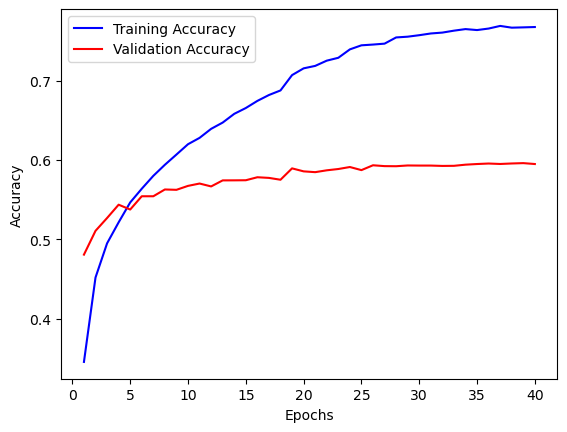

In [41]:
# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , 41, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
plt.plot(np.arange(1 ,41, 1),
         training_history.history['val_accuracy'],
         label = 'Validation Accuracy',
         color = 'red')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()


In [42]:
df_report= pd.read_csv(ds.get_RACINE_SAUVEGARDE() +'df_report.csv')
df_report.head()

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Categorie,precision,recall,f1-score,support,programme,libelle,id
0,0,0.0,0.0,0.0,10,0.454386,0.431667,0.442735,600.0,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
1,1,1.0,1.0,1.0,40,0.409786,0.266932,0.323281,502.0,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
2,2,2.0,2.0,2.0,50,0.233161,0.133929,0.170132,336.0,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
3,3,3.0,3.0,3.0,60,0.123457,0.180723,0.146699,166.0,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01
4,4,4.0,4.0,4.0,1140,0.174033,0.353933,0.233333,534.0,Modele_IMG_Reseau_images_undersampling,undersampling max 2400,UNDER01


In [43]:

report_dict = classification_report(y_test, test_pred_original2, output_dict=True)

# Conversion du rapport de classification en DataFrame
df_report2 = pd.DataFrame(report_dict).transpose()
df_report2['programme']=PGM
df_report2['libelle']=LIBBELLE
df_report2['id']=CNN
df_report2.reset_index(inplace=True)
df_report2 = df_report2.rename(columns={"index": "Categorie"})
df_report=df_report[df_report['id'] != CNN]
df_report = pd.concat([df_report,df_report2])
#df_report.drop('Unnamed: 0',axis=1,inplace=True)
df_report.to_csv(ds.get_RACINE_SAUVEGARDE() +'df_report.csv')
df_report.tail(50)

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Categorie,precision,recall,f1-score,support,programme,libelle,id
608,10.0,NaN,NaN,NaN,1301,0.644444,0.720497,0.680352,161.000000,Model_Img_Reseau_RGB_EfficientNetB1_V01,EfficientNetB1 Adam 4000-2000 SIZE400 DeFreeze...,CNN22
609,11.0,NaN,NaN,NaN,1302,0.542453,0.461847,0.498915,498.000000,Model_Img_Reseau_RGB_EfficientNetB1_V01,EfficientNetB1 Adam 4000-2000 SIZE400 DeFreeze...,CNN22
610,12.0,NaN,NaN,NaN,1320,0.555205,0.543210,0.549142,648.000000,Model_Img_Reseau_RGB_EfficientNetB1_V01,EfficientNetB1 Adam 4000-2000 SIZE400 DeFreeze...,CNN22
611,13.0,NaN,NaN,NaN,1560,0.678738,0.581000,0.626078,1000.000000,Model_Img_Reseau_RGB_EfficientNetB1_V01,EfficientNetB1 Adam 4000-2000 SIZE400 DeFreeze...,CNN22
612,14.0,NaN,NaN,NaN,1920,0.838671,0.821138,0.829812,861.000000,Model_Img_Reseau_RGB_EfficientNetB1_V01,EfficientNetB1 Adam 4000-2000 SIZE400 DeFreeze...,CNN22
613,15.0,NaN,NaN,NaN,1940,0.657143,0.857143,0.743935,161.000000,Model_Img_Reseau_RGB_EfficientNetB1_V01,EfficientNetB1 Adam 4000-2000 SIZE400 DeFreeze...,CNN22
614,16.0,NaN,NaN,NaN,2060,0.599777,0.538539,0.567511,999.000000,Model_Img_Reseau_RGB_EfficientNetB1_V01,EfficientNetB1 Adam 4000-2000 SIZE400 DeFreeze...,CNN22
615,17.0,NaN,NaN,NaN,2220,0.647059,0.466667,0.542254,165.000000,Model_Img_Reseau_RGB_EfficientNetB1_V01,EfficientNetB1 Adam 4000-2000 SIZE400 DeFreeze...,CNN22
616,18.0,NaN,NaN,NaN,2280,0.733138,0.787815,0.759494,952.000000,Model_Img_Reseau_RGB_EfficientNetB1_V01,EfficientNetB1 Adam 4000-2000 SIZE400 DeFreeze...,CNN22
617,19.0,NaN,NaN,NaN,2403,0.669087,0.675393,0.672225,955.000000,Model_Img_Reseau_RGB_EfficientNetB1_V01,EfficientNetB1 Adam 4000-2000 SIZE400 DeFreeze...,CNN22


###  RECUPERER  LES DONNEES SAUVAGARDEES

In [10]:
saveweights = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_weights.h5'
trainacc  = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_train_acc.pkl'
valacc = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_val_acc.pkl'
loss = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_loss.pkl'
valloss = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_valloss.pkl'
dfpredict = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+ '_df_predict.csv'
testoriginal = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_y_test_original2.pkl'
predoriginal = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_test_pred_original2.pkl'

In [12]:
import pickle
with open(trainacc, 'rb') as f:
    train_acc = pickle.load(f)
with open(valacc, 'rb') as f:
    val_acc = pickle.load(f)
with open(loss, 'rb') as f:
    tloss = pickle.load(f)
with open(valloss, 'rb') as f:
    tvalloss = pickle.load(f)    

### b) affichage des precisions et des pertes par époque

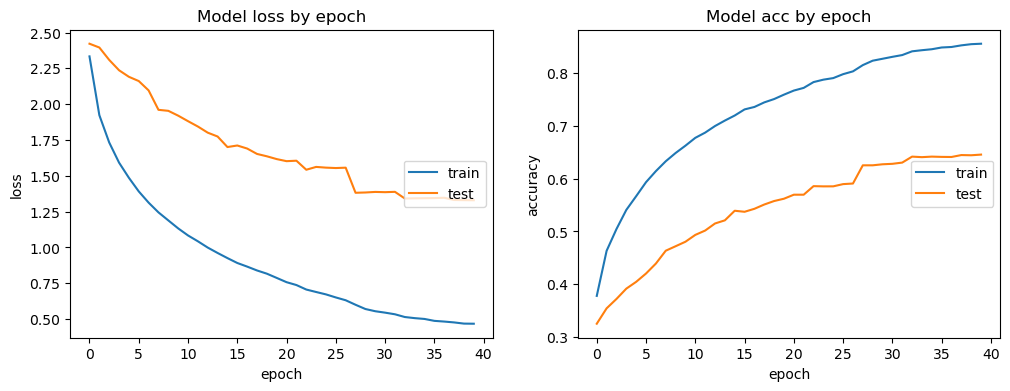

In [13]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tloss)
plt.plot(tvalloss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

### c) affichage des 3 meilleurs prédictions par catégorie
classé par ordre d'échantillonage obtenu après over et under sampling

In [23]:
#=========================================================================
dfp=pd.read_csv(dfpredict)
dfs=pd.read_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE) # effectifs par classe retenu après over et under sampling
dfs.rename({'Unnamed: 0':'Categorie'},axis=1,inplace=True)
df_resume=dfs.merge(dfp,on='Categorie',how='inner')
df_resume.drop('Unnamed: 0',axis=1,inplace=True)
df_resume.head(27)

,Categorie,Qunatity,predict,pourc,predict2,pourc2,predict3,pourc3
0,1560,4000,1560,0.653000,2582,0.086000,2060,0.080000
1,1300,4000,1300,0.827000,1280,0.041000,2585,0.023000
2,2583,4000,2583,0.836000,2585,0.027000,2582,0.021000
3,2060,3994,2060,0.527528,1560,0.093093,1920,0.065065
4,2522,3991,2522,0.745491,1560,0.031062,2585,0.022044
5,1280,3896,1280,0.393224,1300,0.187885,1140,0.068789
6,2403,3819,2403,0.638743,2280,0.156021,10,0.068063
7,2280,3808,2280,0.813025,2403,0.072479,10,0.063025
8,1920,3442,1920,0.829268,1560,0.051103,2060,0.034843
9,1160,3162,1160,0.916561,1281,0.020228,2462,0.013906


### d) matrice de confusion

In [25]:
with open(testoriginal, 'rb') as f:
    y_test_original2 = pickle.load(f)
with open(predoriginal, 'rb') as f:
    test_pred_original2 = pickle.load(f)
with open(ds.get_RACINE_SAUVEGARDE() + 'y_train.pkl', 'rb') as f:
   y_train = pickle.load(f)
with open(ds.get_RACINE_SAUVEGARDE() + 'y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)


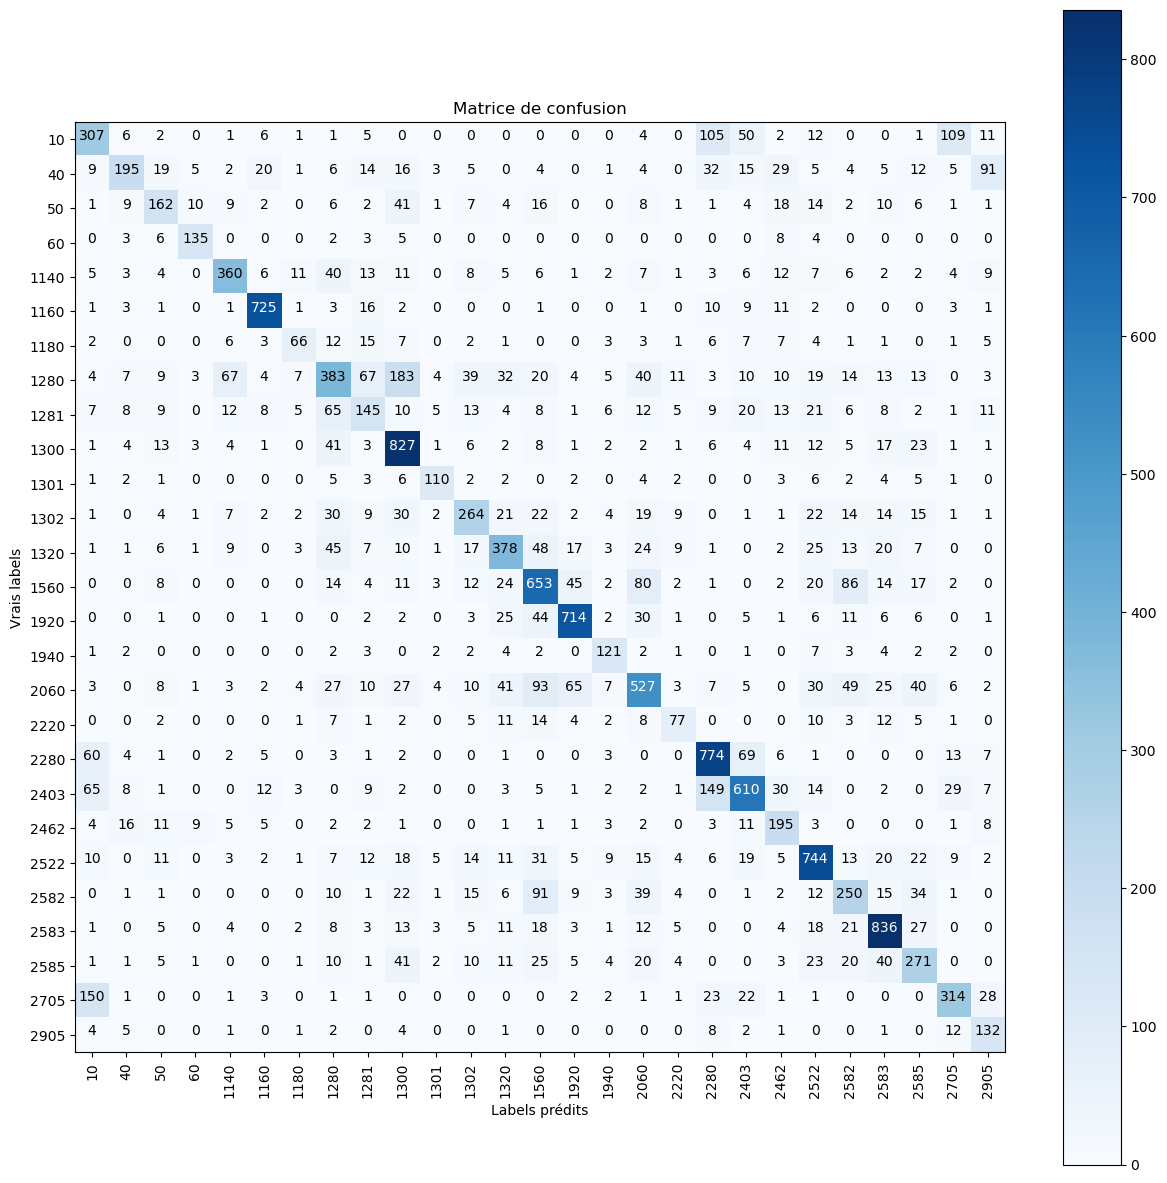

In [26]:
import itertools # Pour créer des itérateurs
#cnf_matrix = confusion_matrix(y_test, test_pred_orinal,labels=[10,2280,2403,2705,40,50,2462,1280,1281])
cnf_matrix = confusion_matrix(y_test, test_pred_original2,labels=sorted(list(set(y_test_original2))))
#print(cnf_matrix)


classes=sorted(list(set(y_test_original2)))
b=list(set(y_test_original2))

plt.figure(figsize=(15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation=90)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()


In [27]:
top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_original2})
df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')
df_cross


predict,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,
10,0.492777,0.009631,0.003210,0.000000,0.001605,0.009631,0.001605,0.001605,0.008026,0.000000,...,0.000000,0.168539,0.080257,0.003210,0.019262,0.000000,0.000000,0.001605,0.174960,0.017657
40,0.017928,0.388446,0.037849,0.009960,0.003984,0.039841,0.001992,0.011952,0.027888,0.031873,...,0.000000,0.063745,0.029880,0.057769,0.009960,0.007968,0.009960,0.023904,0.009960,0.181275
50,0.002976,0.026786,0.482143,0.029762,0.026786,0.005952,0.000000,0.017857,0.005952,0.122024,...,0.002976,0.002976,0.011905,0.053571,0.041667,0.005952,0.029762,0.017857,0.002976,0.002976
60,0.000000,0.018072,0.036145,0.813253,0.000000,0.000000,0.000000,0.012048,0.018072,0.030120,...,0.000000,0.000000,0.000000,0.048193,0.024096,0.000000,0.000000,0.000000,0.000000,0.000000
1140,0.009363,0.005618,0.007491,0.000000,0.674157,0.011236,0.020599,0.074906,0.024345,0.020599,...,0.001873,0.005618,0.011236,0.022472,0.013109,0.011236,0.003745,0.003745,0.007491,0.016854
1160,0.001264,0.003793,0.001264,0.000000,0.001264,0.916561,0.001264,0.003793,0.020228,0.002528,...,0.000000,0.012642,0.011378,0.013906,0.002528,0.000000,0.000000,0.000000,0.003793,0.001264
1180,0.013072,0.000000,0.000000,0.000000,0.039216,0.019608,0.431373,0.078431,0.098039,0.045752,...,0.006536,0.039216,0.045752,0.045752,0.026144,0.006536,0.006536,0.000000,0.006536,0.032680
1280,0.004107,0.007187,0.009240,0.003080,0.068789,0.004107,0.007187,0.393224,0.068789,0.187885,...,0.011294,0.003080,0.010267,0.010267,0.019507,0.014374,0.013347,0.013347,0.000000,0.003080
1281,0.016908,0.019324,0.021739,0.000000,0.028986,0.019324,0.012077,0.157005,0.350242,0.024155,...,0.012077,0.021739,0.048309,0.031401,0.050725,0.014493,0.019324,0.004831,0.002415,0.026570


### e) Rapport de classification

In [28]:
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original2, test_pred_original2)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original2, test_pred_original2)))

Précision de la prédiction: 64.54956652845834 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.48      0.49      0.49       623
          40       0.70      0.39      0.50       502
          50       0.56      0.48      0.52       336
          60       0.80      0.81      0.81       166
        1140       0.72      0.67      0.70       534
        1160       0.90      0.92      0.91       791
        1180       0.60      0.43      0.50       153
        1280       0.52      0.39      0.45       974
        1281       0.41      0.35      0.38       414
        1300       0.64      0.83      0.72      1000
        1301       0.75      0.68      0.71       161
        1302       0.60      0.53      0.56       498
        1320       0.63      0.58      0.61       648
        1560       0.59      0.65      0.62      1000
        1920       0.81      0.83      0.82       861
        1940       0.65      0.7

### f) Résumé de la classification obtenue

In [29]:
df_pred = pd.DataFrame()
for c in Lcat:
    print(c, '   ------   ', catdict[c])
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
    df_pred = pd.concat([df_pred, df_temp], ignore_index=True)
    for index, value in s.items():  # Change ici
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")

10    ------    livres
  : 10,  : 49.28 % , livres
  : 2705,  : 17.5 % , bds et livres
  : 2280,  : 16.85 % , magazines
  : 2403,  : 8.03 % , livres et bds
  : 2522,  : 1.93 % , produits de papeterie et rangement bureau
40    ------    jeux video pour pc et consoles
  : 40,  : 38.84 % , jeux video pour pc et consoles
  : 2905,  : 18.13 % , Jeu En téléchargement
  : 2280,  : 6.37 % , magazines
  : 2462,  : 5.78 % , consoles de jeux video et jeux videos
  : 1160,  : 3.98 % , cartes collectionables
50    ------     accesoires jeux video
  : 50,  : 48.21 % ,  accesoires jeux video
  : 1300,  : 12.2 % , Petites voitures (jouets) et maquettes
  : 2462,  : 5.36 % , consoles de jeux video et jeux videos
  : 1560,  : 4.76 % , Mobilier et produits decoration/rangement pour la maison
  : 2522,  : 4.17 % , produits de papeterie et rangement bureau
60    ------    consoles de jeux video
  : 60,  : 81.33 % , consoles de jeux video
  : 2462,  : 4.82 % , consoles de jeux video et jeux videos
  : 50,  

# I) Recherche du meilleur modèle 
## test sur : optimizer, lrate, nb neuronnes, dropout
### a) premier type

            model = Sequential()
            model.add(base_model) # Ajout du modèle  EfficientNetB1
            model.add(Flatten())
            model.add(Dropout(dprout))
            model.add(Dense(niv1, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(niv1//2, activation='relu'))
            model.add(Dropout(dprout))
            model.add(Dense(27, activation='softmax'))

In [27]:
chemin_du_fichier = ds.get_RACINE_SAUVEGARDE() +'param_grid_'+SUFFIXE_FICHIER+'.csv'
noms_de_colonnes = ['Modele','Lrate', 'NbNeurones_Layer1', 'NbNeurones_Layer2','Dropout','Accuracy','Loss','Val_accuracy','Val_loss']

df_reseaux = pd.DataFrame(columns=noms_de_colonnes)    
# Vérifiez si le fichier existe
if os.path.isfile(chemin_du_fichier):
    # Le fichier existe, le lire
    df_reseaux = pd.read_csv(chemin_du_fichier)
    print("Fichier existant lu avec succès.")
    print(df_reseaux['Lrate'].value_counts())
    print(df_reseaux['NbNeurones_Layer1'].value_counts())
    print(df_reseaux['Dropout'].value_counts())
else:
    # Le fichier n'existe pas, créer un nouveau DataFrame et le sauvegarder
    df_reseaux = pd.DataFrame(columns=noms_de_colonnes)    

Fichier existant lu avec succès.
Lrate
0.00001    18
Name: count, dtype: int64
NbNeurones_Layer1
1024    6
512     6
128     6
Name: count, dtype: int64
Dropout
0.2    6
0.3    6
0.4    6
Name: count, dtype: int64


In [26]:
df_reseaux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         18 non-null     int64  
 1   Modele             18 non-null     object 
 2   Lrate              18 non-null     float64
 3   NbNeurones_Layer1  18 non-null     int64  
 4   NbNeurones_Layer2  18 non-null     int64  
 5   Dropout            18 non-null     float64
 6   Accuracy           18 non-null     object 
 7   Loss               18 non-null     object 
 8   Val_accuracy       18 non-null     object 
 9   Val_loss           18 non-null     object 
dtypes: float64(2), int64(3), object(5)
memory usage: 1.5+ KB


In [26]:
df_reseaux = df_reseaux.drop('Unnamed: 0', axis=1)

df_reseaux[['Modele','Lrate', 'NbNeurones_Layer1', 'Dropout']].head()

,Modele,Lrate,NbNeurones_Layer1,Dropout
0,Adam,0.00001,1024,0.2
1,SGD,0.00001,1024,0.2
2,Adam,0.00001,1024,0.3
3,SGD,0.00001,1024,0.3
4,Adam,0.00001,1024,0.4


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model


#for lrate in  [1e-5,5e-6,1e-6]:
for lrate in  [1e-5]:    
    for niv1 in [1024,512,128]:   
        for dprout in [0.20,0.30,0.40]:
            print("=====================  Adam   ============================")
            print("=====================  categorical_crossentropy   ============================")
            print('lrate = ' ,lrate)
            print('niv1 = ' ,niv1,niv1//2)
            print('dprout = ' ,dprout)
            condition = (
                (df_reseaux['Modele'] == 'Adam') &
                (df_reseaux['Lrate'] == lrate) &
                (df_reseaux['NbNeurones_Layer1'] == niv1) &
                (df_reseaux['Dropout'] == dprout)
            )
            on_execute = True
            if df_reseaux[condition].any().any():
                print("On passe")
                on_execute = False
            model = Sequential()
            model.add(base_model) # Ajout du modèle  EfficientNetB1
            model.add(Flatten())
            model.add(Dropout(dprout))
            model.add(Dense(niv1, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(niv1//2, activation='relu'))
            model.add(Dropout(dprout))
            model.add(Dense(27, activation='softmax'))
            if on_execute :
                model.compile(optimizer=Adam(learning_rate=lrate), loss='categorical_crossentropy', metrics=['accuracy'])
                #print(model.summary())
                training_history = model.fit(dataset_train, epochs=3, validation_data = dataset_test)
                train_acc = training_history.history['accuracy']
                val_acc = training_history.history['val_accuracy']
                tloss = training_history.history['loss']
                tvalloss=training_history.history['val_loss']
                df_reseaux.loc[len(df_reseaux)] = ['Adam',lrate, niv1,niv1//2, dprout,train_acc,tloss,val_acc,tvalloss]
                print(type(df_reseaux))
                print('Adam',lrate, niv1, dprout,train_acc,tloss,val_acc,tvalloss)
                #df_reseaux = df_reseaux.append({'Modele': 'Adam', 'Lrate': lrate, 'NbNeurones_Layer1': niv1,
                #        'NbNeurones_Layer2': niv1//2, 'Dropout': dprout, 'TrainAcc': train_acc, 'Tloss': tloss,
                #        'ValAcc': val_acc, 'Tvalloss': tvalloss})
                df_reseaux.to_csv( chemin_du_fichier)       
                #del training_history
                #gc.collect()
            print("=====================  SGD   ============================")
            print("=====================  categorical_crossentropy   ============================")
            print('lrate = ' ,lrate)
            print('niv1 = ' ,niv1,niv1//2)
            print('dprout = ' ,dprout)
            on_execute = True
            condition = (
                (df_reseaux['Modele'] == 'SGD') &
                (df_reseaux['Lrate'] == lrate) &
                (df_reseaux['NbNeurones_Layer1'] == niv1) &
                (df_reseaux['Dropout'] == dprout)
            )
            if df_reseaux[condition].any().any():
                print("On passe")
                on_execute = False
            model = Sequential()
            model.add(base_model) # Ajout du modèle  EfficientNetB1
            model.add(Flatten())
            model.add(Dropout(dprout))
            model.add(Dense(niv1, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(niv1//2, activation='relu'))
            model.add(Dropout(dprout))
            model.add(Dense(27, activation='softmax'))
            if on_execute :
                model.compile(optimizer=SGD(learning_rate=lrate), loss='categorical_crossentropy', metrics=['accuracy'])
                training_history = model.fit(dataset_train, epochs=3, validation_data = dataset_test)
                train_acc = training_history.history['accuracy']
                val_acc = training_history.history['val_accuracy']
                tloss = training_history.history['loss']
                tvalloss=training_history.history['val_loss']
                df_reseaux.loc[len(df_reseaux)] = ['SGD',lrate, niv1,niv1//2, dprout,train_acc,tloss,val_acc,tvalloss]
                #df_reseaux = df_reseaux.append({'Modele': 'SGD', 'Lrate': lrate, 'NbNeurones_Layer1': niv1,
                #        'NbNeurones_Layer2': niv1//2, 'Dropout': dprout, 'TrainAcc': train_acc, 'Tloss': tloss,
                #        'ValAcc': val_acc, 'Tvalloss': tvalloss}, ignore_index=True)
                df_reseaux.to_csv( chemin_du_fichier)       
                #del training_history
                #gc.collect()
                print("=========================================================")
                print(df_reseaux)
df_reseaux.to_csv( chemin_du_fichier)            

=====================  Adam   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024 512
dprout =  0.2
On passe
=====================  SGD   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024 512
dprout =  0.2
On passe
=====================  Adam   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024 512
dprout =  0.3
On passe
=====================  SGD   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024 512
dprout =  0.3
On passe
=====================  Adam   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024 512
dprout =  0.4
On passe
=====================  SGD   ========

In [28]:
df_reseaux['Val_acc']=df_reseaux['Val_accuracy'].apply(lambda x : eval(x)[3])
df_reseaux[['Modele','Lrate','NbNeurones_Layer1','Dropout','Val_acc']].nlargest(5,'Val_acc')

,Modele,Lrate,NbNeurones_Layer1,Dropout,Val_acc
16,Adam,0.00001,128,0.4,0.537253
10,Adam,0.00001,512,0.4,0.494849
12,Adam,0.00001,128,0.2,0.494158
14,Adam,0.00001,128,0.3,0.480965
8,Adam,0.00001,512,0.3,0.445408


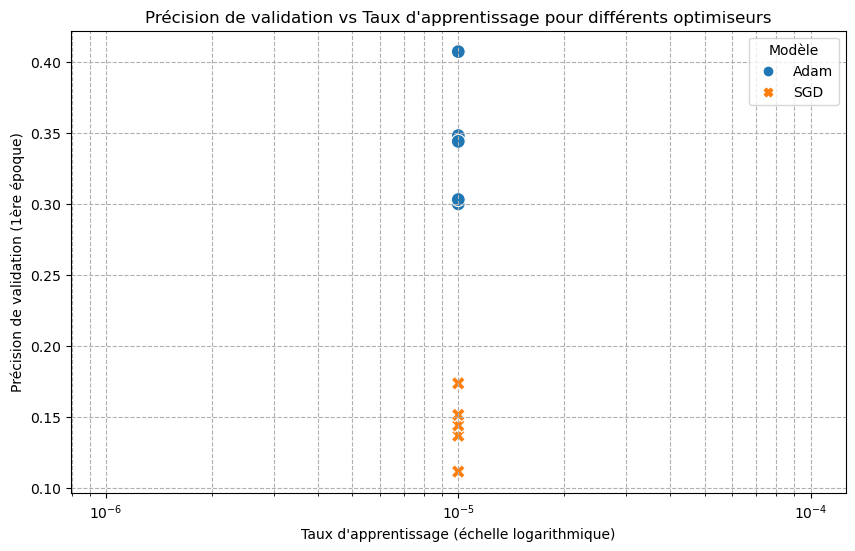

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Charger le fichier CSV
file_path = chemin_du_fichier  # Remplacez par le chemin réel du fichier
data = pd.read_csv(file_path)

# Convertir les chaînes de liste en listes réelles pour 'Val_accuracy'
data['Val_accuracy'] = data['Val_accuracy'].apply(ast.literal_eval)

# Extraire la première valeur de précision de validation pour chaque configuration
data['Val_accuracy_first_epoch'] = data['Val_accuracy'].apply(lambda x: x[0])

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Lrate', y='Val_accuracy_first_epoch', hue='Modele', style='Modele', s=100)
plt.xscale('log')
plt.xlabel('Taux d\'apprentissage (échelle logarithmique)')
plt.ylabel('Précision de validation (1ère époque)')
plt.title('Précision de validation vs Taux d\'apprentissage pour différents optimiseurs')
plt.legend(title='Modèle')
plt.grid(True, which="both", ls="--")
plt.show()


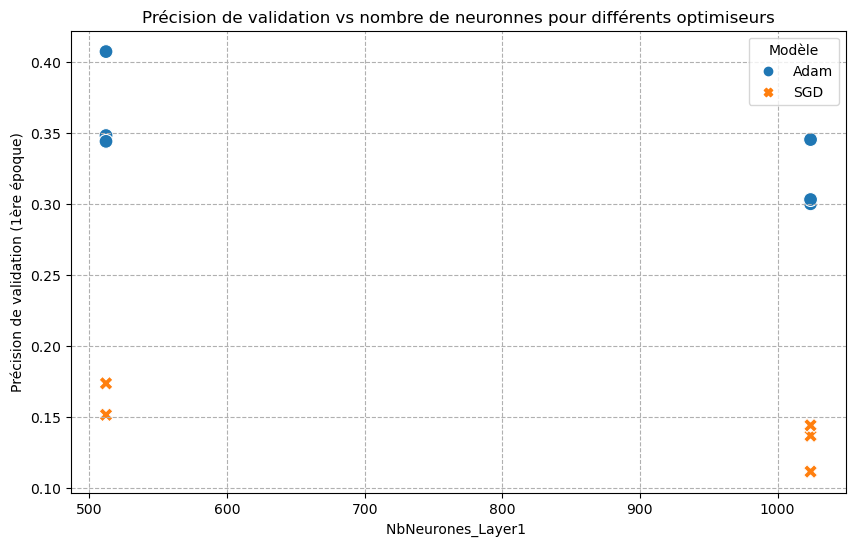

In [28]:
data = pd.read_csv(file_path)

# Convertir les chaînes de liste en listes réelles pour 'Val_accuracy'
data['Val_accuracy'] = data['Val_accuracy'].apply(ast.literal_eval)

# Extraire la première valeur de précision de validation pour chaque configuration
data['Val_accuracy_first_epoch'] = data['Val_accuracy'].apply(lambda x: x[0])

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='NbNeurones_Layer1', y='Val_accuracy_first_epoch', hue='Modele', style='Modele', s=100)
plt.xscale('linear')
plt.xlabel('NbNeurones_Layer1 ')
plt.ylabel('Précision de validation (1ère époque)')
plt.title('Précision de validation vs nombre de neuronnes pour différents optimiseurs')
plt.legend(title='Modèle')
plt.grid(True, which="both", ls="--")
plt.show()

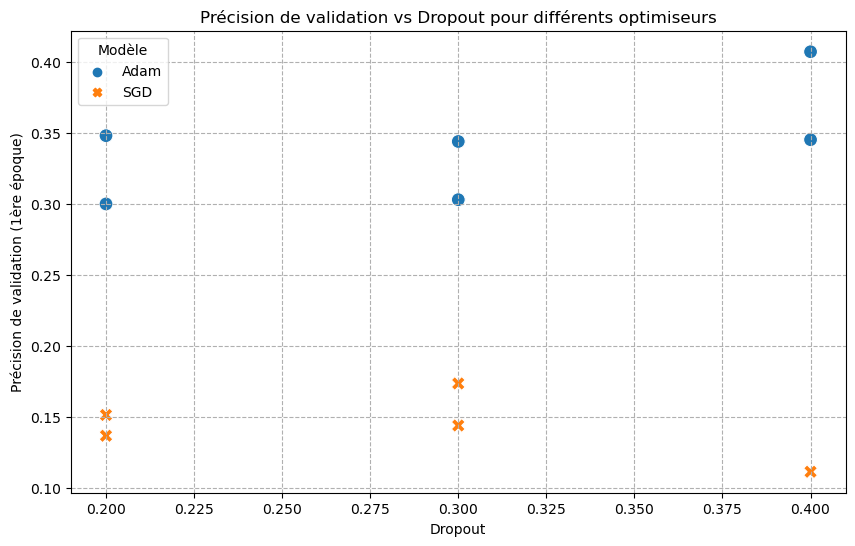

In [29]:
data = pd.read_csv(file_path)

# Convertir les chaînes de liste en listes réelles pour 'Val_accuracy'
data['Val_accuracy'] = data['Val_accuracy'].apply(ast.literal_eval)

# Extraire la première valeur de précision de validation pour chaque configuration
data['Val_accuracy_first_epoch'] = data['Val_accuracy'].apply(lambda x: x[0])

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Dropout', y='Val_accuracy_first_epoch', hue='Modele', style='Modele', s=100)
plt.xscale('linear')
plt.xlabel('Dropout')
plt.ylabel('Précision de validation (1ère époque)')
plt.title('Précision de validation vs Dropout pour différents optimiseurs')
plt.legend(title='Modèle')
plt.grid(True, which="both", ls="--")
plt.show()

### a) deuxième type

            model = Sequential()
            model.add(base_model) # Ajout du modèle  EfficientNetB1
            model.add(Flatten())
            model.add(Dropout(dprout))
            model.add(Dense(niv1, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(niv1, activation='relu'))
            model.add(Dropout(dprout))
            model.add(Dense(27, activation='softmax'))

In [29]:
chemin_du_fichier_2 = ds.get_RACINE_SAUVEGARDE() +'param_grid2_'+SUFFIXE_FICHIER+'.csv'
noms_de_colonnes = ['Modele','Lrate', 'NbNeurones_Layer1', 'NbNeurones_Layer2','Dropout','Accuracy','Loss','Val_accuracy','Val_loss']

df_reseaux_2 = pd.DataFrame(columns=noms_de_colonnes)  
  
# Vérifiez si le fichier existe
if os.path.isfile(chemin_du_fichier_2):
    # Le fichier existe, le lire
    df_reseaux_2 = pd.read_csv(chemin_du_fichier_2)
    print("Fichier existant lu avec succès.")
    print(df_reseaux_2['Lrate'].value_counts())
    print(df_reseaux_2['NbNeurones_Layer1'].value_counts())
    print(df_reseaux_2['Dropout'].value_counts())
else:
    # Le fichier n'existe pas, créer un nouveau DataFrame et le sauvegarder
    df_reseaux_2 = pd.DataFrame(columns=noms_de_colonnes)   

Fichier existant lu avec succès.
Lrate
0.00001    18
Name: count, dtype: int64
NbNeurones_Layer1
1024    6
512     6
256     6
Name: count, dtype: int64
Dropout
0.2    6
0.3    6
0.4    6
Name: count, dtype: int64


In [24]:
df_reseaux_2.head()

,Unnamed: 0,Modele,Lrate,NbNeurones_Layer1,NbNeurones_Layer2,Dropout,Accuracy,Loss,Val_accuracy,Val_loss
0,0,Adam,0.00001,1024,1024,0.2,"[0.4143654406070709, 0.5051276087760925, 0.551...","[2.1405375003814697, 1.7471896409988403, 1.548...","[0.2779243588447571, 0.31090590357780457, 0.34...","[2.7276244163513184, 2.5889012813568115, 2.415..."
1,1,SGD,0.00001,1024,1024,0.2,"[0.06799690425395966, 0.12639056146144867, 0.1...","[3.632648468017578, 3.3191423416137695, 3.1182...","[0.15875110030174255, 0.25103655457496643, 0.3...","[3.1085240840911865, 2.802311897277832, 2.5989..."
2,2,Adam,0.00001,1024,1024,0.3,"[0.40415099263191223, 0.4934869110584259, 0.53...","[2.205925941467285, 1.798893690109253, 1.60479...","[0.307701975107193, 0.35004398226737976, 0.374...","[2.5918357372283936, 2.442429304122925, 2.3218..."
3,3,SGD,0.00001,1024,1024,0.3,"[0.056750111281871796, 0.1078224927186966, 0.1...","[3.7082154750823975, 3.4052348136901855, 3.199...","[0.15353688597679138, 0.24789546430110931, 0.3...","[3.069866895675659, 2.76082706451416, 2.558560..."
4,4,Adam,0.00001,1024,1024,0.4,"[0.38612622022628784, 0.46891510486602783, 0.5...","[2.3098976612091064, 1.9064180850982666, 1.695...","[0.3215228021144867, 0.36656615138053894, 0.38...","[2.579277515411377, 2.378835678100586, 2.33233..."


In [25]:
df_reseaux_2 = df_reseaux_2.drop('Unnamed: 0', axis=1)

df_reseaux_2[['Modele','Lrate', 'NbNeurones_Layer1', 'Dropout']].head()

,Modele,Lrate,NbNeurones_Layer1,Dropout
0,Adam,0.00001,1024,0.2
1,SGD,0.00001,1024,0.2
2,Adam,0.00001,1024,0.3
3,SGD,0.00001,1024,0.3
4,Adam,0.00001,1024,0.4


In [26]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
#for lrate in [1e-5,5e-6,1e-6]:
for lrate in [1e-5]:    
    for niv1 in [1024,512,256]:   
        for dprout in [0.20,0.30,0.40]:   
            print("=====================  Adam   ============================")
            print("=====================  categorical_crossentropy   ============================")
            print('lrate = ' ,lrate)
            print('niv1 = ' ,niv1)
            print('dprout = ' ,dprout)
            condition = (
                (df_reseaux_2['Modele'] == 'Adam') &
                (df_reseaux_2['Lrate'] == lrate) &
                (df_reseaux_2['NbNeurones_Layer1'] == niv1) &
                (df_reseaux_2['Dropout'] == dprout)
            )
            on_execute = True
            if df_reseaux_2[condition].any().any():
                print("On passe")
                on_execute = False
            model = Sequential()
            model.add(base_model) # Ajout du modèle  EfficientNetB1
            model.add(Flatten())
            model.add(Dropout(dprout))
            model.add(Dense(niv1, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(niv1, activation='relu'))
            model.add(Dropout(dprout))
            model.add(Dense(27, activation='softmax'))
            if on_execute :    
                model.compile(optimizer=Adam(learning_rate=lrate), loss='categorical_crossentropy', metrics=['accuracy'])
                training_history = model.fit(dataset_train, epochs=4, validation_data = dataset_test)
                train_acc = training_history.history['accuracy']
                val_acc = training_history.history['val_accuracy']
                tloss = training_history.history['loss']
                tvalloss=training_history.history['val_loss']
                df_reseaux_2.loc[len(df_reseaux_2)] = ['Adam',lrate, niv1,niv1, dprout,train_acc,tloss,val_acc,tvalloss]
                df_reseaux_2.to_csv( chemin_du_fichier_2) 
            print("=====================  SGD   ============================")
            print("=====================  categorical_crossentropy   ============================")
            print('lrate = ' ,lrate)
            print('niv1 = ' ,niv1)
            print('dprout = ' ,dprout)
            on_execute = True
            condition = (
                (df_reseaux_2['Modele'] == 'SGD') &
                (df_reseaux_2['Lrate'] == lrate) &
                (df_reseaux_2['NbNeurones_Layer1'] == niv1) &
                (df_reseaux_2['Dropout'] == dprout)
            )
            if df_reseaux_2[condition].any().any():
                print("On passe")
                on_execute = False
            model = Sequential()
            model.add(base_model) # Ajout du modèle  EfficientNetB1
            model.add(Flatten())
            model.add(Dropout(dprout))
            model.add(Dense(niv1, activation='relu'))
            model.add(BatchNormalization())
            model.add(Dense(niv1, activation='relu'))
            model.add(Dropout(dprout))
            model.add(Dense(27, activation='softmax'))
            if on_execute :  
                model.compile(optimizer=SGD(learning_rate=lrate), loss='categorical_crossentropy', metrics=['accuracy'])
                training_history = model.fit(dataset_train, epochs=4, validation_data = dataset_test)
                train_acc = training_history.history['accuracy']
                val_acc = training_history.history['val_accuracy']
                tloss = training_history.history['loss']
                tvalloss=training_history.history['val_loss']
                df_reseaux_2.loc[len(df_reseaux_2)] = ['SGD',lrate, niv1,niv1, dprout,train_acc,tloss,val_acc,tvalloss]
                df_reseaux_2.to_csv( chemin_du_fichier_2) 
                print("=========================================================")
                print(df_reseaux_2)
df_reseaux_2.to_csv( chemin_du_fichier_2)                 

=====================  Adam   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024
dprout =  0.2
On passe
=====================  SGD   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024
dprout =  0.2
On passe
=====================  Adam   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024
dprout =  0.3
On passe
=====================  SGD   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024
dprout =  0.3
On passe
=====================  Adam   ============================
=====================  categorical_crossentropy   ============================
lrate =  1e-05
niv1 =  1024
dprout =  0.4
On passe
=====================  SGD   ============================

In [31]:
df_reseaux_2['Val_acc']=df_reseaux_2['Val_accuracy'].apply(lambda x : eval(x)[3])
df_reseaux_2[['Modele','Lrate','NbNeurones_Layer1','Dropout','Val_acc']].nlargest(5,'Val_acc')

,Modele,Lrate,NbNeurones_Layer1,Dropout,Val_acc
16,Adam,0.00001,256,0.4,0.507601
14,Adam,0.00001,256,0.3,0.484232
10,Adam,0.00001,512,0.4,0.469154
12,Adam,0.00001,256,0.2,0.457030
8,Adam,0.00001,512,0.3,0.445282
